In [1]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import scanpy.external as sce
from itertools import islice, cycle
from sklearn.preprocessing import normalize

from ALLCools.clustering import tsne, significant_pc_test, filter_regions, remove_black_list_region, lsi, binarize_matrix
from ALLCools.plot import *

In [6]:
metadata = pd.read_csv("Allcells.clustering.csv")

/tmp/ipykernel_1337587/1742850445.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("Allcells.clustering.csv")


In [7]:
metadata

,cell,batch,cell_type,sampleID,Sample,annotation,mCGFrac,CG_Rate,mCHFrac,CH_Rate,exposure,leiden,tsne_0,tsne_1,all_tsne_0,all_tsne_1,all_leiden,mCG_level
0,HIV_1_R1_C0_NK-cell_pre,14,NK-cell,HIV_1,NaN,NK-cell2,0.838423,0.838423,NaN,0.006892,HIV_pre,5,8.291620,15.384555,8.291620,15.384555,5,0.838423
1,HIV_1_R1_D0_NK-cell_pre,14,NK-cell,HIV_1,NaN,NK-cell2,0.828414,0.828414,NaN,0.007265,HIV_pre,5,7.509774,21.156825,7.509774,21.156825,5,0.828414
2,HIV_1_R1_C1_NK-cell_pre,14,NK-cell,HIV_1,NaN,NK-cell1,0.674925,0.674925,NaN,0.006458,HIV_pre,9,35.802468,-4.933715,35.802468,-4.933715,9,0.674925
3,HIV_1_R1_D1_NK-cell_pre,14,NK-cell,HIV_1,NaN,NK-cell2,0.833997,0.833997,NaN,0.006662,HIV_pre,5,17.436298,25.756629,17.436298,25.756629,5,0.833997
4,HIV_3_R1_C0_NK-cell_cro,14,NK-cell,HIV_3,NaN,NK-cell2,0.840103,0.840103,NaN,0.016103,HIV,5,19.895280,28.635705,19.895280,28.635705,5,0.840103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100341,Ctrl_14_2-Ctrl_15_2-E8-AD006,6,Th-Mem,Ctrl_14,NaN,Th-Mem,0.769500,NaN,0.009259,NaN,Ctrl,4,-3.397689,-66.462863,-3.397689,-66.462863,4,0.769500
100342,Ctrl_14_2-Ctrl_15_2-E8-AD007,6,Th-Mem,Ctrl_15,NaN,Th-Mem,0.755906,NaN,0.007206,NaN,Ctrl,4,0.726475,-62.586677,0.726475,-62.586677,4,0.755906
100343,Ctrl_14_2-Ctrl_15_2-E8-AD008,6,Th-Mem,Ctrl_15,NaN,Th-Mem,0.692419,NaN,0.007778,NaN,Ctrl,4,-10.967276,-31.782477,-10.967276,-31.782477,4,0.692419
100344,Ctrl_14_2-Ctrl_15_2-E8-AD010,6,Th-Mem,Ctrl_15,NaN,Th-Mem,0.755576,NaN,0.007014,NaN,Ctrl,7,-18.544617,-9.872121,-18.544617,-9.872121,7,0.755576


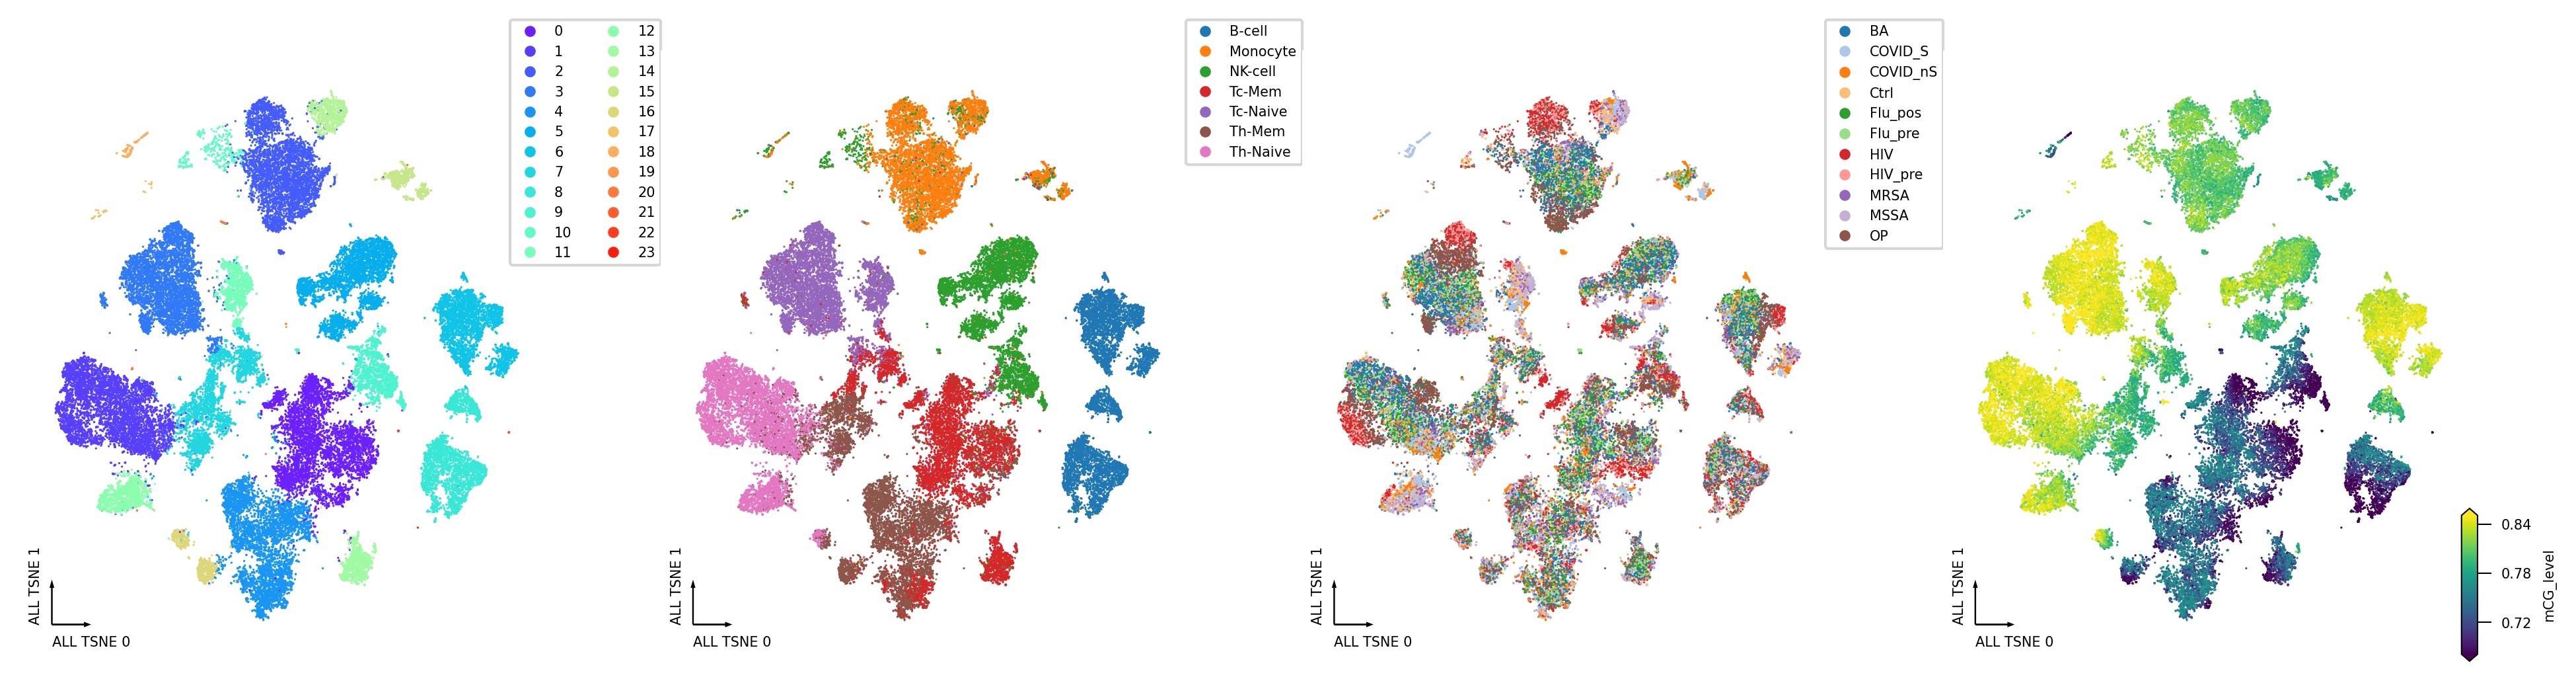

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=metadata, ax=axes[0], coord_base='all_tsne', hue='all_leiden', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=metadata, ax=axes[1], coord_base='all_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=metadata, ax=axes[2], coord_base='all_tsne', hue='exposure', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=metadata, ax=axes[3], coord_base='all_tsne', hue='mCG_level', labelsize=5, hue_norm=[0.681167, 0.850626])
plt.savefig("Figure3AB.All_clusters.pdf")

## Figure 3C

In [10]:
count_stat = pd.read_csv('eDMR_count.stat', sep="\t")

In [11]:
count_stat = count_stat[count_stat['Celltype']!='Monocyte1']

In [12]:
all_eDMRs = pd.read_csv("all_eDMRs.bed", sep="\t", names=['chrom', 'start', 'end', 'Celltype', 'Exposure', 'hypo_in'])

In [13]:
all_eDMRs['State'] = ['hypo' if x not in ['pre', 'D1', 'Ctrl'] else 'hyper' for x in all_eDMRs['hypo_in']]

In [23]:
count_stat = all_eDMRs[['Celltype', 'Exposure', 'State']].value_counts().reset_index().rename({0:'count'}, axis=1)

In [24]:
count_stat = count_stat[count_stat['Celltype']!='Monocyte1']
count_stat['expo_cell'] = count_stat['Exposure'] + "_" + count_stat['Celltype']

In [16]:
from matplotlib.colors import rgb2hex
color_plate = sns.color_palette("tab20b")
color_plate = [rgb2hex(x) for x in color_plate]

cell2color = {'AA': 'white',
            'B-Mem': color_plate[2],
             'B-Naive': color_plate[3],
             'Monocyte': color_plate[6],
             # 'Monocyte1': color_plate[7],
             'NK-cell1': color_plate[10],
             'NK-cell2': color_plate[11],
              
             'Tc-Mem': color_plate[14],
             'Tc-Naive': color_plate[15],
             'Th-Mem': color_plate[18],
             'Th-Naive': color_plate[19]}

color_plate = sns.color_palette("Set3", 8)
color_plate = [rgb2hex(x) for x in color_plate]

expo2color = {'HIV': color_plate[0],
             'Flu': color_plate[1],
             'COVID': color_plate[2],
             'MRSA': color_plate[3],
             'BA': color_plate[4],
             'OP': color_plate[5]}


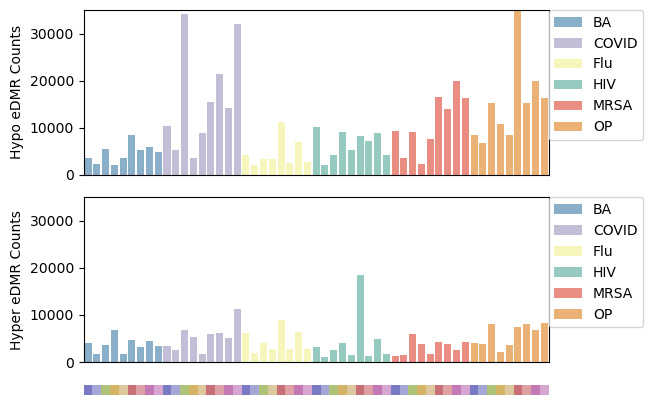

In [25]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 5), height_ratios=(8, 8, 0.5))

sns.barplot(data=count_stat[count_stat['State']=='hypo'].sort_values(by=['Exposure', 'Celltype']), x='expo_cell', y='count', hue='Exposure',ax=axs[0], palette=expo2color)
axs[0].xaxis.set_visible(False)
axs[0].set_ylabel('Hypo eDMR Counts')
axs[0].set_ylim(0, 35000)
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)

sns.barplot(data=count_stat[count_stat['State']=='hyper'].sort_values(by=['Exposure', 'Celltype']), x='expo_cell', y='count', hue='Exposure',ax=axs[1], palette=expo2color)
axs[1].xaxis.set_visible(False)
axs[1].set_ylim(0, 35000)
axs[1].set_ylabel('Hyper eDMR Counts')
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)

sns.barplot(data=count_stat[count_stat['State']=='hypo'].sort_values(by=['Exposure', 'Celltype']), x='expo_cell', y=1, hue='Celltype', legend=False, ax=axs[2], width=1, palette=cell2color)
plt.axis('off')
plt.savefig('Figure3C.eDMR_count.pdf')

## Figure 3D

In [26]:
from matplotlib.colors import rgb2hex

color_plate = sns.color_palette("tab20b")
color_plate = [rgb2hex(x) for x in color_plate]

cell2color = {'B-Mem': color_plate[2],
             'B-Naive': color_plate[3],
             'Monocyte': color_plate[6],
             # 'Monocyte1': color_plate[7],
             'NK-cell1': color_plate[10],
             'NK-cell2': color_plate[11],
              
             'Tc-Mem': color_plate[14],
             'Tc-Naive': color_plate[15],
             'Th-Mem': color_plate[18],
             'Th-Naive': color_plate[19]}

color_plate = sns.color_palette("Set3", 8)
color_plate = [rgb2hex(x) for x in color_plate]

expo2color = {'HIV': color_plate[0],
              'acu': color_plate[0],
              'cro': color_plate[0],
             'Flu': color_plate[1],
             'COVID': color_plate[2],
              'non-Severe': color_plate[2],
              'Severe': color_plate[2],
             'MRSA': color_plate[3],
              'MSSA': color_plate[3],
             'BA': color_plate[4],
              'frequent': color_plate[4],
              'unfrequent': color_plate[4],
             'OP': color_plate[5],
              'Low': color_plate[5],
              'Med': color_plate[5],
              'High': color_plate[5],
             'Ctrl': 'red'}


maincond2color = {
              'acu': color_plate[0],
              'cro': color_plate[0],
              'non-Severe': color_plate[2],
              'Severe': color_plate[2],
              'MSSA': color_plate[3],
             'Ctrl': 'red'}

supcond2color = {
              
             'Flu': color_plate[1],
             
             'MRSA': color_plate[3],
             'BA': color_plate[4],
              'frequent': color_plate[4],
              'unfrequent': color_plate[4],
             'OP': color_plate[5],
              'Low': color_plate[5],
              'Med': color_plate[5],
              'High': color_plate[5],
             'Ctrl': 'red'}

In [32]:
exposure_features = pd.read_csv("eDMR.Histone.Enrich.csv")

In [33]:
exposure_features

,feature,DMR,pvalue,odds_ratio,effect_size,fdr,-log10(FDR),log2(odds_ratio),exposure,condition
0,H3K27ac_Monocyte,HIV_acu_eDMR_B-Mem,1.254259e-20,0.548536,0.028625,5.867136e-20,19.231574,-0.866342,HIV,acu
1,H3K27ac_Monocyte,HIV_pre_eDMR_B-Mem,3.770518e-05,0.730590,0.012821,7.109871e-05,4.148138,-0.452867,HIV,pre
2,H3K27ac_Monocyte,HIV_cro_eDMR_B-Mem,1.329771e-03,0.815998,0.009932,2.142106e-03,2.669159,-0.293363,HIV,cro
3,H3K27ac_Monocyte,HIV_cro_eDMR_B-Naive,9.821419e-01,1.009541,0.000070,9.907989e-01,0.004014,0.013699,HIV,cro
4,H3K27ac_Monocyte,HIV_pre_eDMR_B-Naive,1.263575e-03,1.375091,0.010135,2.039334e-03,2.690512,0.459527,HIV,pre
...,...,...,...,...,...,...,...,...,...,...
8635,H3K9me3_Th-Naive,Flu_D28_eDMR_Tc-Naive,5.572702e-01,1.108382,0.001833,6.038014e-01,0.219106,0.148455,Flu,D28
8636,H3K9me3_Th-Naive,Flu_D28_eDMR_Th-Mem,2.892339e-07,1.524844,0.015685,6.557303e-07,6.183275,0.608661,Flu,D28
8637,H3K9me3_Th-Naive,Flu_D1_eDMR_Th-Mem,8.339959e-05,1.415809,0.012057,1.524649e-04,3.816830,0.501627,Flu,D1
8638,H3K9me3_Th-Naive,Flu_D28_eDMR_Th-Naive,1.971956e-01,1.216756,0.004025,2.355991e-01,0.627826,0.283040,Flu,D28


In [34]:
select_feature = [x for x in exposure_features['feature'] if x.startswith('H3')]
hist_features = exposure_features[exposure_features['feature'].isin(select_feature)]

In [36]:
df_col = hist_features[['DMR']].set_index('DMR')
df_col['Exposure'] = [x.split("_")[0] for x in df_col.index]
df_col['Condition'] = [x.split("_")[1] for x in df_col.index]
df_col['DMRtype'] = [x.split("_")[2] if len(x.split("_")) > 2 else 'Merge' for x in df_col.index]
df_col['Celltype'] = [x.split("_")[3] if len(x.split("_")) > 2  else 'Merge' for x in df_col.index]


df_row = hist_features[['feature']].set_index('feature')
df_row[['Feature', 'Type']] = [[x.split("_")[0], "_".join(x.split('_'))] for x in df_row.index]
df_row['Celltype'] = [x.split("_")[-1] if x.startswith("H3") else 'Tc-Mem' for x in df_row['Type']]
# df_row['Feature'] = ['Genomic_' + x if not x.startswith('H3') else x for x in df_row['Feature']]
df_row['Type'] = [x.split("_")[0] if x.startswith('H3') else re.sub("\w+_", '', x) for x in df_row['Type']]
df_row = df_row.drop_duplicates()
df_col = df_col.drop_duplicates()
df_col = df_col[df_col['Celltype']!='Monocyte1']

In [43]:
convert_labels = {'pre': 'Ctrl', 'acu': 'acu', 'cro': 'cro', 'frequent': 'frequent', 'unfrequent': 'unfrequent', 'D1': 'Ctrl', 'D28': 'Flu', 'Low': 'Low',
                 'Med': 'Med', 'High': 'High', 'C': 'non-Severe', 'W': 'Severe', 'Ctrl': 'Ctrl', 'MSSA': 'MSSA', 'MRSA': 'MRSA'}

In [44]:
df_col['Condition'] = df_col.Condition.map(convert_labels)

In [38]:
exposure_features =exposure_features[exposure_features['DMR'].isin(df_col.index)]
hist_features =hist_features[hist_features['DMR'].isin(df_col.index)]

In [40]:
from PyComplexHeatmap import *

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 19.024539687980617
Starting plotting HeatmapAnnotations
Plotting legends..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


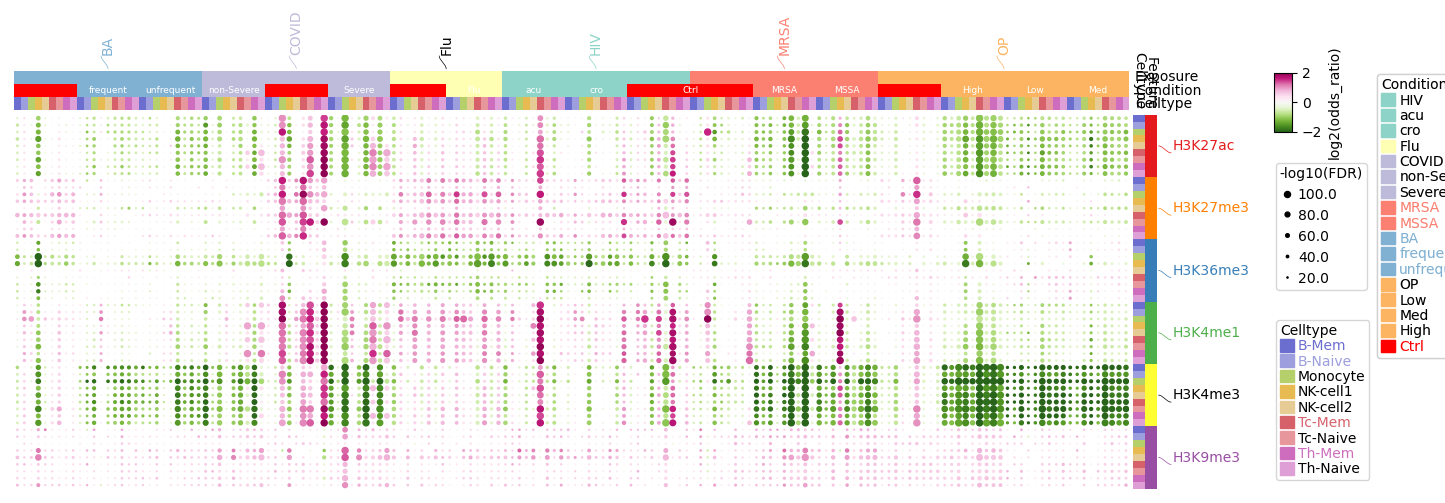

In [45]:
row_ha = HeatmapAnnotation(
                            Celltype=anno_simple(df_row.Celltype,cmap='Set1',legend=False,add_text=False, colors=cell2color),
                            Feature=anno_simple(df_row.Feature,cmap='Set1',add_text=False,legend=False),
                            label=anno_label(df_row.Type, merge=True,rotation=0, extend=True, arrowprops={'visible': True}),axis=0
                            )

col_ha = HeatmapAnnotation(
                            label=anno_label(df_col.Exposure, colors=expo2color, merge=True),
                           Exposure=anno_simple(df_col.Exposure,cmap='Set1',legend=False,add_text=False, colors=expo2color),
                            Condition=anno_simple(df_col.Condition,cmap='Set1',legend=True,add_text=True, colors=expo2color),
                           Celltype=anno_simple(df_col.Celltype,cmap='Set1',legend=True,add_text=False, colors=cell2color),
                            
                           verbose=0)

plt.figure(figsize=(15, 5))
cm = DotClustermapPlotter(data=exposure_features, x='DMR',y='feature',value='log2(odds_ratio)',s='-log10(FDR)',c='log2(odds_ratio)',
                           row_cluster=False,col_cluster=False,
                          cmap='PiYG_r',
                          top_annotation=col_ha,right_annotation=row_ha, 
                          col_split_gap=0.5,row_split_gap=1, 
                          show_rownames=False,show_colnames=False,row_dendrogram=False, spines=False,grid=None,
                          verbose=1,legend_gap=7,alpha=1)

In [42]:
main_figure = exposure_features[exposure_features['exposure'].isin(['HIV', 'COVID', 'MRSA'])]
main_figure = main_figure[~main_figure['condition'].isin(['MRSA'])]

In [46]:
Ctrl_plot = main_figure[main_figure['condition'].isin(['Ctrl', 'pre', 'D1'])]
hyper_same_cell = main_figure[main_figure.apply(lambda row: row.feature.split("_")[-1] == row.DMR.split("_")[-1], axis=1)]
hyper_same_cell['feature'] = [x.split("_")[0] for x in hyper_same_cell['feature']]

/tmp/ipykernel_1337587/570361581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hyper_same_cell['feature'] = [x.split("_")[0] for x in hyper_same_cell['feature']]


In [47]:
df_col = hyper_same_cell[['DMR']].set_index('DMR')
df_col['Exposure'] = [x.split("_")[0] for x in df_col.index]
df_col['Condition'] = [x.split("_")[1] for x in df_col.index]
df_col['DMRtype'] = [x.split("_")[2] if len(x.split("_")) > 2 else 'Merge' for x in df_col.index]
df_col['Celltype'] = [x.split("_")[3] if len(x.split("_")) > 2  else 'Merge' for x in df_col.index]


df_row = hyper_same_cell[['feature']].set_index('feature')
df_row[['Feature', 'Type']] = [[x.split("_")[0], "_".join(x.split('_'))] for x in df_row.index]
df_row['Celltype'] = [x.split("_")[-1] if x.startswith("H3") else 'Tc-Mem' for x in df_row['Type']]
# df_row['Feature'] = ['Genomic_' + x if not x.startswith('H3') else x for x in df_row['Feature']]
df_row['Type'] = [x.split("_")[0] if x.startswith('H3') else re.sub("\w+_", '', x) for x in df_row['Type']]
df_row = df_row.drop_duplicates()
df_col = df_col.drop_duplicates()
df_col['Condition'] = df_col.Condition.map(convert_labels)

In [48]:
y_order = ['H3K4me1', 'H3K27ac', 'H3K4me3', 'H3K36me3', 'H3K27me3', 'H3K9me3']
x_order = sorted(hyper_same_cell['DMR'].unique())

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 42.35188858005135
Starting plotting HeatmapAnnotations
Plotting legends..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol


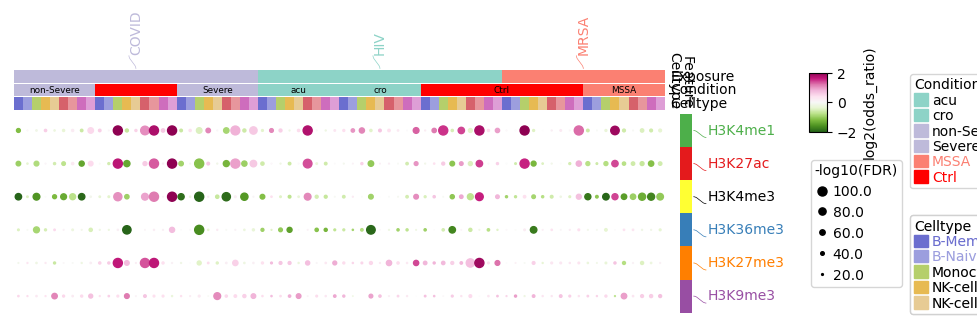

In [49]:
row_ha = HeatmapAnnotation(
                            Celltype=anno_simple(df_row.Celltype,cmap='Set1',legend=False,add_text=False, colors=cell2color),
                            Feature=anno_simple(df_row.Feature,cmap='Set1',add_text=False,legend=False),
                            label=anno_label(df_row.Type, merge=True,rotation=0, extend=True, arrowprops={'visible': True}),axis=0
                            )

col_ha = HeatmapAnnotation(
                            label=anno_label(df_col.Exposure, colors=expo2color, merge=True),
                           Exposure=anno_simple(df_col.Exposure,cmap='Set1',legend=False,add_text=False, colors=expo2color),
                            Condition=anno_simple(df_col.Condition,cmap='Set1',legend=True,add_text=True, colors=maincond2color),
                           Celltype=anno_simple(df_col.Celltype,cmap='Set1',legend=True,add_text=False, colors=cell2color),
                            
                           verbose=0)
df_col['expo_cond'] = df_col['Exposure']+"-"+df_col['Condition']
plt.figure(figsize=(9, 3))
cm1 = DotClustermapPlotter(data=hyper_same_cell, x='DMR',y='feature',value='log2(odds_ratio)',s='-log10(FDR)',c='log2(odds_ratio)',
                           row_cluster=False,col_cluster=False, y_order=y_order,x_order=x_order,
                          cmap='PiYG_r',
                          top_annotation=col_ha,right_annotation=row_ha, 
                          col_split_gap=0.5,row_split_gap=1,
                          show_rownames=False,show_colnames=False,row_dendrogram=False, spines=False,grid=None,
                          verbose=1,legend_gap=7,alpha=1)
plt.savefig("Figure3D.eDMR_Histone_enrich.main.combine.pdf",bbox_inches='tight')

## Figure 3E

#### Bed files for the eDMRs in each cell type and each exposure were feed to HOMER to do motif enrichment

In [50]:
motif_pvalue_df = pd.read_csv('eDMR.motif.enrich.csv', index_col=0)

### Step1. Motif selection

In [52]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_fillna = motif_pvalue_df.T.fillna(1)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_fillna)

pca = PCA(n_components=10)
principal_components = pca.fit_transform(df_scaled)

# Create a new DataFrame containing the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

pca.explained_variance_ratio_

array([0.14561604, 0.09185499, 0.0651955 , 0.04703292, 0.04321249,
       0.03534294, 0.02751057, 0.02218646, 0.02100933, 0.01971772])

In [53]:
components = pca.components_

# Create a DataFrame for better visualization
components_df = pd.DataFrame(components, columns=motif_pvalue_df.T.columns, index=[f'Component_{i+1}' for i in range(components.shape[0])])

In [54]:
top_features_per_component = {}
top_motifs = []
for i in range(components.shape[0]):
    # Sort the features by the absolute values of their coefficients for each component
    sorted_features = components_df.iloc[i].abs().sort_values(ascending=False)
    
    # Get the top 10 features
    top_features = sorted_features.head(5).index.tolist()
    top_features_per_component[f'Component_{i+1}'] = top_features
    top_motifs += top_features

# Print the top 5 features for each component
for component, features in top_features_per_component.items():
    print(f"{component}: {features}")

Component_1: ['TCF4(bHLH)', 'RAR:RXR(NR),DR5', 'NF1-halfsite(CTF)', 'BHLHA15(bHLH)', 'Smad2(MAD)']
Component_2: ['Hoxd12(Homeobox)', 'KLF5(Zf)', 'THRb(NR)', 'EAR2(NR)', 'COUP-TFII(NR)']
Component_3: ['E2A(bHLH),near_PU.1', 'Tgif1(Homeobox)', 'FoxD3(forkhead)', 'GATA3(Zf),DR8', 'Tcfcp2l1(CP2)']
Component_4: ['GFY(?)', 'NFY(CCAAT)', 'Dlx3(Homeobox)', 'Isl1(Homeobox)', 'Hoxb4(Homeobox)']
Component_5: ['ARE(NR)', 'FOXK2(Forkhead)', 'Brn2(POU,Homeobox)', 'CEBP(bZIP)', 'CEBP:AP1(bZIP)']
Component_6: ['DMRT1(DM)', 'ZNF189(Zf)', 'PRDM1(Zf)', 'Hoxa10(Homeobox)', 'IRF3(IRF)']
Component_7: ['RORa(NR)', 'NPAS(bHLH)', 'CLOCK(bHLH)', 'Rbpj1(?)', 'PRDM14(Zf)']
Component_8: ['KLF3(Zf)', 'DUX4(Homeobox)', 'En1(Homeobox)', 'Bach1(bZIP)', 'Tbx21(T-box)']
Component_9: ['Tbx5(T-box)', 'Tcf3(HMG)', 'Pitx1(Homeobox)', 'Oct11(POU,Homeobox)', 'Tcf7(HMG)']
Component_10: ['FOXM1(Forkhead)', 'PSE(SNAPc)', 'ZNF7(Zf)', 'LHX9(Homeobox)', 'Lhx3(Homeobox)']


In [55]:
topdiff = [x for list in top_features_per_component.values() for x in list]

In [56]:
hypo = motif_pvalue_df.loc[topdiff, [x for x in motif_pvalue_df.columns if x.startswith('hypo')]]
hyper = motif_pvalue_df.loc[topdiff, [x for x in motif_pvalue_df.columns if x.startswith('hyper')]]

In [57]:
hypo = hypo.dropna(how='all')
hyper = hyper.dropna(how='all')
hypo['Motif'] = hypo.index
hypo_melt = hypo.melt(var_name='Group', id_vars='Motif', value_name='Q-Value')
hyper['Motif'] = hyper.index
hyper_melt = hyper.melt(var_name='Group', id_vars='Motif', value_name='Q-Value')

In [58]:
hypo_melt.dropna(inplace=True)
hyper_melt.dropna(inplace=True)
hypo_melt['cell'] = hypo_melt['Group'].apply(lambda x: x.split("_")[-1])
hyper_melt['cell'] = hyper_melt['Group'].apply(lambda x: x.split("_")[-1])
hypo_melt = hypo_melt.sort_values(by=['Group', 'Motif'])
hyper_melt = hyper_melt.sort_values(by=['Group', 'Motif'])
hypo_melt = hypo_melt[hypo_melt['cell']!= "Monocyte1"]
hyper_melt = hyper_melt[hyper_melt['cell']!= "Monocyte1"]
hypo_df_col = pd.DataFrame(index=hypo_melt['Group'].unique())
hyper_df_col = pd.DataFrame(index=hyper_melt['Group'].unique())
hypo_df_col['Expo'] = [re.sub("[0-9]+\.", "", x.split("_")[1]) for x in hypo_df_col.index]
hyper_df_col['Expo'] = [re.sub("[0-9]+\.", "", x.split("_")[1]) for x in hyper_df_col.index]

In [59]:
hypo_melt['-log10(FDR)'] = -np.log10(hypo_melt['Q-Value'])
hyper_melt['-log10(FDR)'] = -np.log10(hyper_melt['Q-Value'])
hypo_melt['-log10(FDR)'] = [100 if x > 100 else x for x in hypo_melt['-log10(FDR)'].tolist()]
hyper_melt['-log10(FDR)'] = [100 if x > 100 else x for x in hyper_melt['-log10(FDR)'].tolist()]
hypo_melt['color'] = hypo_melt['cell'].map(cell2color)
hyper_melt['color'] = hyper_melt['cell'].map(cell2color)
hypo_melt.drop_duplicates(inplace=True)
hyper_melt.drop_duplicates(inplace=True)

/gale/netapp/DoD/wenliang/bin/miniconda3_4.9.2/envs/echo/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/gale/netapp/DoD/wenliang/bin/miniconda3_4.9.2/envs/echo/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Using user provided max_s: 20
Plotting legends..


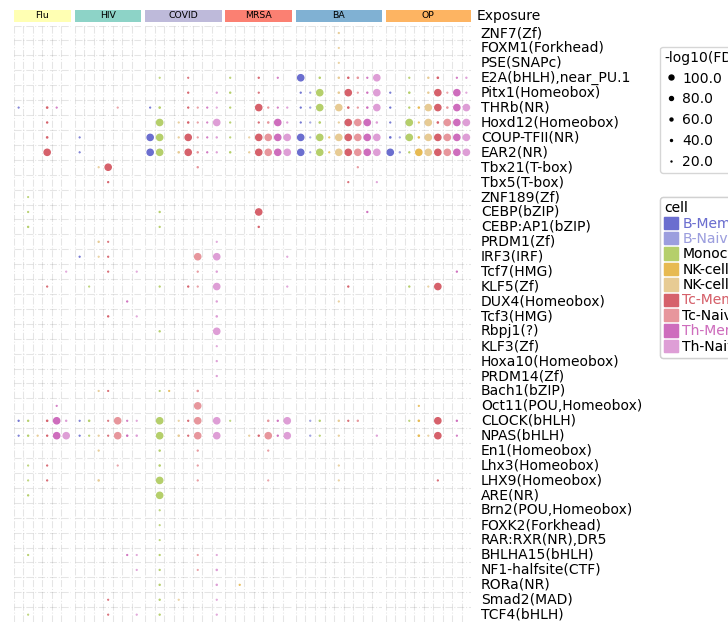

In [60]:
col_ha1 = HeatmapAnnotation(Exposure=anno_simple(hypo_df_col.Expo,cmap='Set1',colors=expo2color, legend=False,add_text=True),
                           verbose=0)

plt.figure(figsize=(6, 8))
cm1 = DotClustermapPlotter(data=hypo_melt, x='Group',y='Motif',s='-log10(FDR)', c=hypo_melt['color'],hue='cell',value='-log10(FDR)',
                           row_cluster=True,col_cluster=False,c_na='white', colors=cell2color,legend=True,
                          top_annotation=col_ha1,
                          col_split_gap=1,col_split=hypo_df_col.Expo,
                          show_rownames=True,show_colnames=False,row_dendrogram=False,max_s=20,
                          verbose=1,legend_gap=7,alpha=0.8)
plt.savefig("FigureS4D.hypo_eDMRs.motif.pdf")

In [61]:
x_order = sorted(hyper_melt['Group'].unique())

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 55.98614321398873
Plotting legends..


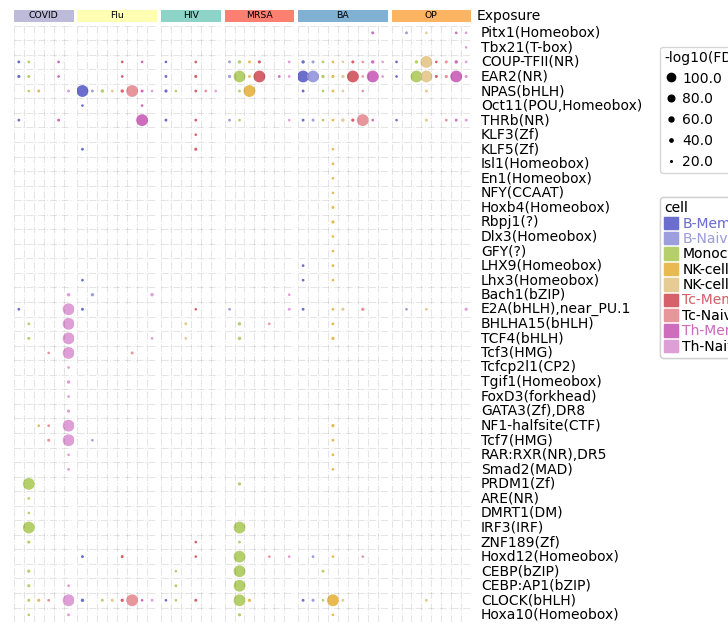

In [62]:
col_ha2 = HeatmapAnnotation(Exposure=anno_simple(hyper_df_col.Expo,cmap='Set1',colors=expo2color, legend=False,add_text=True),
                           verbose=0)
plt.figure(figsize=(6, 8))

cm2 = DotClustermapPlotter(data=hyper_melt, x='Group',y='Motif',s='-log10(FDR)', c=hyper_melt['color'],hue='cell',value='-log10(FDR)',
                           row_cluster=True,col_cluster=False,c_na='white',colors=cell2color,x_order=x_order,
                          top_annotation=col_ha2, col_split=hyper_df_col.Expo,
                          col_split_gap=1,
                          show_rownames=True,show_colnames=False,row_dendrogram=False,
                          verbose=1,legend_gap=7,alpha=0.8)
plt.savefig("Figure3E.hyper_eDMRs.motif.pdf")